In [1]:
import os
import sys
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from scipy.spatial import distance
from scipy.cluster import hierarchy
# from eval import load_model, get_prediction_and_ground_truths, eval_zeolite_aggregated, eval_zeolite_osda, eval_single_system, get_metric_dataframes
# from data.metrics import maximum_mean_discrepancy, wasserstein_distance

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def rmsd_matrix(A, B, squared=False, axis = 0):
    """
    Compute all pairwise distances between vectors in A and B.

    Parameters
    ----------
    A : np.array
        shape should be (M, K)
    B : np.array
        shape should be (N, K)

    Returns
    -------
    D : np.array
        A matrix D of shape (M, N).  Each entry in D i,j represnets the
        distance between row i in A and row j in B.

    See also
    --------
    A more generalized version of the distance matrix is available from
    scipy (https://www.scipy.org) using scipy.spatial.distance_matrix,
    which also gives a choice for p-norm.
    """
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    if axis == 0:
        D_squared =  1/M*(A_dots + B_dots -2*A.dot(B.T))
    elif axis == 1:
        D_squared =  1/N*(A_dots + B_dots -2*A.dot(B.T))

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

def smoothsegment(seg, Nsmooth=100):
    '''
    Helper function for plotting circular dendrogram
    '''

    return np.concatenate([[seg[0]], np.linspace(seg[1], seg[2], Nsmooth), [seg[3]]])

In [3]:
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)

In [4]:
data = dataset.get_datapoints_by_index(range(len(dataset)), scaled=False, return_dataframe=True)
x_syn_ratio, zeo_code, osda_smiles = data[1], data[3], data[13]
x_syn_ratio['zeo'], x_syn_ratio['osda'] = zeo_code, osda_smiles
x_syn_ratio

Si/Al      Al/P  Si/Ge   Si/B  Na/T   K/T      OH/T  F/T      H2O/T  \
0      400.0  0.000000   99.0  250.0   0.0  0.05  0.250000  0.0  31.000006   
1      400.0  0.000000   99.0  250.0   0.0  0.00  0.000000  0.5   7.500000   
2      400.0  0.000000   99.0  250.0   0.0  0.12  0.270000  0.0  44.000000   
3      400.0  0.000000   99.0  250.0   0.0  0.00  0.000000  0.5  20.000000   
4        2.5  1.717997   99.0  250.0   0.0  0.00  2.285717  0.0  28.571430   
...      ...       ...    ...    ...   ...   ...       ...  ...        ...   
23956   30.0  1.717997   99.0  250.0   0.0  0.00  0.000000  0.0   0.000000   
23957   40.0  1.717997   99.0  250.0   0.0  0.00  0.000000  0.0   0.000000   
23958   70.0  1.717997   99.0  250.0   0.0  0.00  0.000000  0.0   0.000000   
23959  100.0  1.717997   99.0  250.0   0.0  0.00  0.000000  0.0   0.000000   
23960  300.0  1.717997   99.0  250.0   0.0  0.00  0.000000  0.0   0.000000   

         sda1/T  cryst_temp  cryst_time  zeo  \
0      0.200000  150.000000  504.000000  AFI   
1      0.500000  175.000000  168.000000  AFI   
2      0.150000  150.000000  144.000000  AFI   
3      0.000000  115.720856  660.165100  AFI   
4      1.142857  125.000000   72.000000  BPH   
...         ...         ...         ...  ...   
23956  0.000000  135.000000  558.916321  CHA   
23957  0.000000  160.000000  240.032150  CHA   
23958  0.000000  170.000000   53.891212  AFI   
23959  0.000000  170.000000  193.911392  AFI   
23960  0.000000  160.000000  342.733093  AFI   

                                                    osda  
0      C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...  
1      C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...  
2                        C[N+](C)(C)C12CC3CC(CC(C3)C1)C2  
3                        C[N+](C)(C)C12CC3CC(CC(C3)C1)C2  
4                                       CC[N+](CC)(CC)CC  
...                                                  ...  
23956                       CC[N+]1(CC)CC2CC3CC(C2)CC1C3  
23957                       CC[N+]1(CC)CC2CC3CC(C2)CC1C3  
23958                       CC[N+]1(CC)CC2CC3CC(C2)CC1C3  
23959                       CC[N+]1(CC)CC2CC3CC(C2)CC1C3  
23960                       CC[N+]1(CC)CC2CC3CC(C2)CC1C3  

[23961 rows x 14 columns]

In [5]:
# Get unique list of zeolites
unique_zeos = list(x_syn_ratio['zeo'].value_counts().index)
for zeo in unique_zeos:
    remove = False
    if 'Dense' in zeo:
        remove = True
    if '/' in zeo:
        remove = True
    if remove:
        unique_zeos.remove(zeo)

unique_zeos = unique_zeos[:50]

In [6]:
# Featurize each zeolite with the mean and std of the synthesis ratios and synthesis conditions
zeo_feats = []
for zeo in unique_zeos:
    syn_mean = x_syn_ratio[x_syn_ratio['zeo']==zeo].drop(columns=['zeo', 'osda']).mean()
    syn_std = x_syn_ratio[x_syn_ratio['zeo']==zeo].drop(columns=['zeo', 'osda']).std().fillna(0).rename(lambda x: x+'_std')
    syn_mean_std = pd.concat([syn_mean, syn_std], axis=0)

    zeo_feats.append(syn_mean_std)
zeo_feats = pd.DataFrame(pd.concat(zeo_feats, axis=1).T, columns=syn_mean_std.index)
zeo_feats['zeo'] = unique_zeos
zeo_feats

Si/Al      Al/P      Si/Ge        Si/B      Na/T       K/T      OH/T  \
0   234.812805  0.917506  95.778160  235.968262  0.148871  0.027697  0.239021   
1    36.000309  1.090811  85.555656  213.424469  0.067966  0.051151  0.116842   
2   200.584259  0.923173  90.259178  235.189362  0.082331  0.006954  0.223009   
3    24.160595  0.768018  22.862745   55.568260  0.003239  0.001623  0.008409   
4   267.393768  0.771811  96.214653  236.392517  0.099177  0.003921  0.211627   
5    74.143143  1.020635  58.972145  180.755402  0.468066  0.000450  0.642206   
6    16.730663  1.608891  94.836998  239.926743  0.820670  0.008145  0.810754   
7    46.413464  1.675742  98.797546  248.486710  0.520997  0.017665  0.436392   
8   169.065811  1.062638  97.293106  192.112213  0.122632  0.175360  0.193178   
9   209.152328  1.107355  95.064987  239.746689  0.129105  0.072290  0.153517   
10    0.072437  0.894749  35.377522   89.337173  0.000383  0.000000  0.000000   
11   54.181770  1.533959  95.000000  234.106064  0.168260  0.010413  0.134543   
12  364.828308  0.147992  12.629766  214.706055  0.000000  0.007004  0.029830   
13   14.319060  1.235906  67.269234  169.871796  0.156376  0.000000  0.088636   
14  155.752808  1.412575  96.800003  237.777771  0.122563  0.035833  0.152796   
15   71.476089  1.125543  86.688889  200.236938  0.127504  0.005778  0.141337   
16   65.542404  1.499342  95.400002  238.657944  0.657427  0.077570  0.719405   
17  377.364777  0.094137  12.106518  142.778122  0.000000  0.000000  0.305627   
18   82.041031  1.247775  87.728859  226.190475  0.884577  0.006891  1.158423   
19    0.000242  0.875165   0.478261    1.207729  0.003138  0.000000  0.000000   
20    5.750373  1.550104  86.129997  217.500000  0.714195  0.073826  0.918863   
21  228.098114  0.679849  90.529411  222.070724  0.104546  0.018642  0.192367   
22  191.009308  0.452591  65.709679  163.292175  0.054495  0.019431  0.171900   
23  263.635559  0.717405  87.200294  203.903351  0.017889  0.009679  0.067225   
24  286.008850  0.930187  88.237572  225.483429  0.136488  0.014309  0.217809   
25  179.918869  0.411725  24.775385  138.039627  0.000000  0.000000  0.106755   
26  326.319946  0.405638  25.788391  243.682861  0.000000  0.000000  0.003472   
27   10.524013  1.618013  95.013985  241.258743  0.889435  0.000000  0.849776   
28  329.485718  0.404957  12.203032  142.779129  0.000000  0.000000  0.133710   
29    0.082105  0.987690  44.328358  111.940300  0.000000  0.000000  0.000000   
30  189.343597  0.957357  41.237484  231.573029  0.000000  0.000000  0.007634   
31   11.904639  1.489623  81.070869  204.724411  0.141569  0.217811  0.445362   
32  312.492249  0.525338  99.000000  236.319504  0.041333  0.000000  0.040101   
33  155.976425  1.303308  87.275047  210.089447  0.148187  0.000000  0.187084   
34  389.473694  0.000000  47.270931  243.421051  0.000000  0.000000  0.000000   
35   21.700804  1.641980  97.247787  245.575226  0.548191  0.033854  0.259587   
36  238.894897  1.043069  87.063515  247.611603  0.054269  0.000000  0.292791   
37  117.709091  1.296307  97.199997  178.425583  0.120736  0.000413  0.094916   
38  315.584625  0.726845  94.314400  240.576920  0.058356  0.020444  0.150847   
39   38.703129  1.516806  98.048080  247.596161  0.120244  0.547015  0.495121   
40  275.555878  0.555312   2.263451  222.402756  0.000000  0.000000  0.000000   
41  368.504395  0.126589  53.567772  235.610519  0.000000  0.000000  0.040351   
42  331.548889  0.347690  96.642860  159.571381  0.016365  0.000000  0.137012   
43    6.493503  1.717997  99.000000  250.000000  0.177537  0.066999  0.734106   
44   18.596127  1.676094  96.585365  241.041855  0.025344  0.410100  0.453805   
45  187.711548  0.858999  92.310814  207.889572  0.008250  0.069249  0.286848   
46  374.439423  0.096789   4.931672  199.812668  0.000000  0.000000  0.352871   
47  400.000000  0.049797  99.000000  250.000000  0.080982  0.000000  0.551933   
48    9.217903  1.436347  82.746269  205

# Zeolite hierarchical clustering

In [7]:
zeo_feats_T = zeo_feats.T.drop(index='zeo')
zeo_feats_T.columns = zeo_feats['zeo']
zeo_feats_T

zeo                    MFI         CHA         BEA         AFI         MTW  \
Si/Al           234.812805   36.000309  200.584259   24.160595  267.393768   
Al/P              0.917506    1.090811    0.923173    0.768018    0.771811   
Si/Ge             95.77816   85.555656   90.259178   22.862745   96.214653   
Si/B            235.968262  213.424469  235.189362    55.56826  236.392517   
Na/T              0.148871    0.067966    0.082331    0.003239    0.099177   
K/T               0.027697    0.051151    0.006954    0.001623    0.003921   
OH/T              0.239021    0.116842    0.223009    0.008409    0.211627   
F/T               0.084773    0.086628    0.170464    0.041064    0.106432   
H2O/T              36.3521   22.950012   16.476418   29.431057    38.85635   
sda1/T            0.336729     0.57567    0.335711    0.545752    0.307537   
cryst_temp      157.132751  170.786743   150.72052  172.688217  156.464279   
cryst_time      129.198441   85.840958  210.474197   68.636848  271.319489   
Si/Al_std       173.782028  103.235039  185.090057   94.643425  166.006546   
Al/P_std          0.857179    0.527759    0.856963     0.38135    0.855275   
Si/Ge_std        16.684647   33.897865    26.67952   41.744579   16.342781   
Si/B_std          54.98534   88.287636   56.812405  103.727066    54.07523   
Na/T_std           0.28482    0.187668    0.189851    0.018092    0.182421   
K/T_std           0.166973    0.197041    0.044431     0.01612    0.030401   
OH/T_std          0.287174    0.292142    0.296808     0.04893    0.247215   
F/T_std             0.2608    0.225935    0.241487    0.122903     0.20054   
H2O/T_std        36.940475   30.382151   22.592487   42.505108   45.862514   
sda1/T_std        0.615807    0.962957    0.322947     0.84068    0.356268   
cryst_temp_std   31.235201   36.670269   27.432575   23.122162   19.278879   
cryst_time_std  221.771515  108.198372   192.35994  117.425781  377.763214   

zeo                    LTA         FAU         MOR         MWW         TON  \
Si/Al            74.143143   16.730663   46.413464  169.065811  209.152328   
Al/P              1.020635    1.608891    1.675742    1.062638    1.107355   
Si/Ge            58.972145   94.836998   98.797546   97.293106   95.064987   
Si/B            180.755402  239.926743   248.48671  192.112213  239.746689   
Na/T              0.468066     0.82067    0.520997    0.122632    0.129105   
K/T                0.00045    0.008145    0.017665     0.17536     0.07229   
OH/T              0.642206    0.810754    0.436392    0.193178    0.153517   
F/T               0.162985    0.001772    0.015825    0.115483    0.093882   
H2O/T            36.957428   35.125847   30.818159   29.734591   36.099159   
sda1/T            1.142661    0.124709    0.224894    0.430358    0.487803   
cryst_temp       127.07222   102.36869  156.910736  153.935989  168.334091   
cryst_time      107.896431  124.009933  136.420029  199.402328  140.993271   
Si/Al_std       153.689972   64.761261   89.687004  179.562958   174.04007   
Al/P_std          0.730914    0.385901    0.258994    0.835412    0.823403   
Si/Ge_std        48.096348   19.870396    4.476937   12.900712   19.356857   
Si/B_std        111.977501   49.206558   19.281796  104.602402   48.984482   
Na/T_std          0.707461     0.69845    0.352253    0.211653    0.232587   
K/T_std           0.010602    0.072026    0.098339    0.827094     0.32405   
OH/T_std           0.86522    0.756198    0.346179    0.383701    0.241843   
F/T_std           0.242708    0.015008    0.086742    0.286524    0.246272   
H2O/T_std        43.309921   44.703358   19.439035   27.916807   37.156441   
sda1/T_std        1.696704    0.288973    0.836092    0.334255     0.69326   
cryst_temp_std   43.200043     35.5578    27.82147   23.092169   34.092495   
cryst_time_std  163.926453   141.28801  109.861275  286.501678  221.606628   

zeo             ...         IRR         ISV         SVY       MRT         SZR  \
Si/Al           .

In [8]:
zeo_feats_T_scaled = (zeo_feats_T-zeo_feats_T.min())/(zeo_feats_T.max()-zeo_feats_T.min()).astype(float)
zeo_feats_T_scaled = zeo_feats_T_scaled.astype(float)

In [9]:
zeo_rmsd = pd.DataFrame(rmsd_matrix(zeo_feats_T_scaled.T.to_numpy(), zeo_feats_T_scaled.T.to_numpy()),
                        index=zeo_feats_T_scaled.columns, columns=zeo_feats_T_scaled.columns)

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


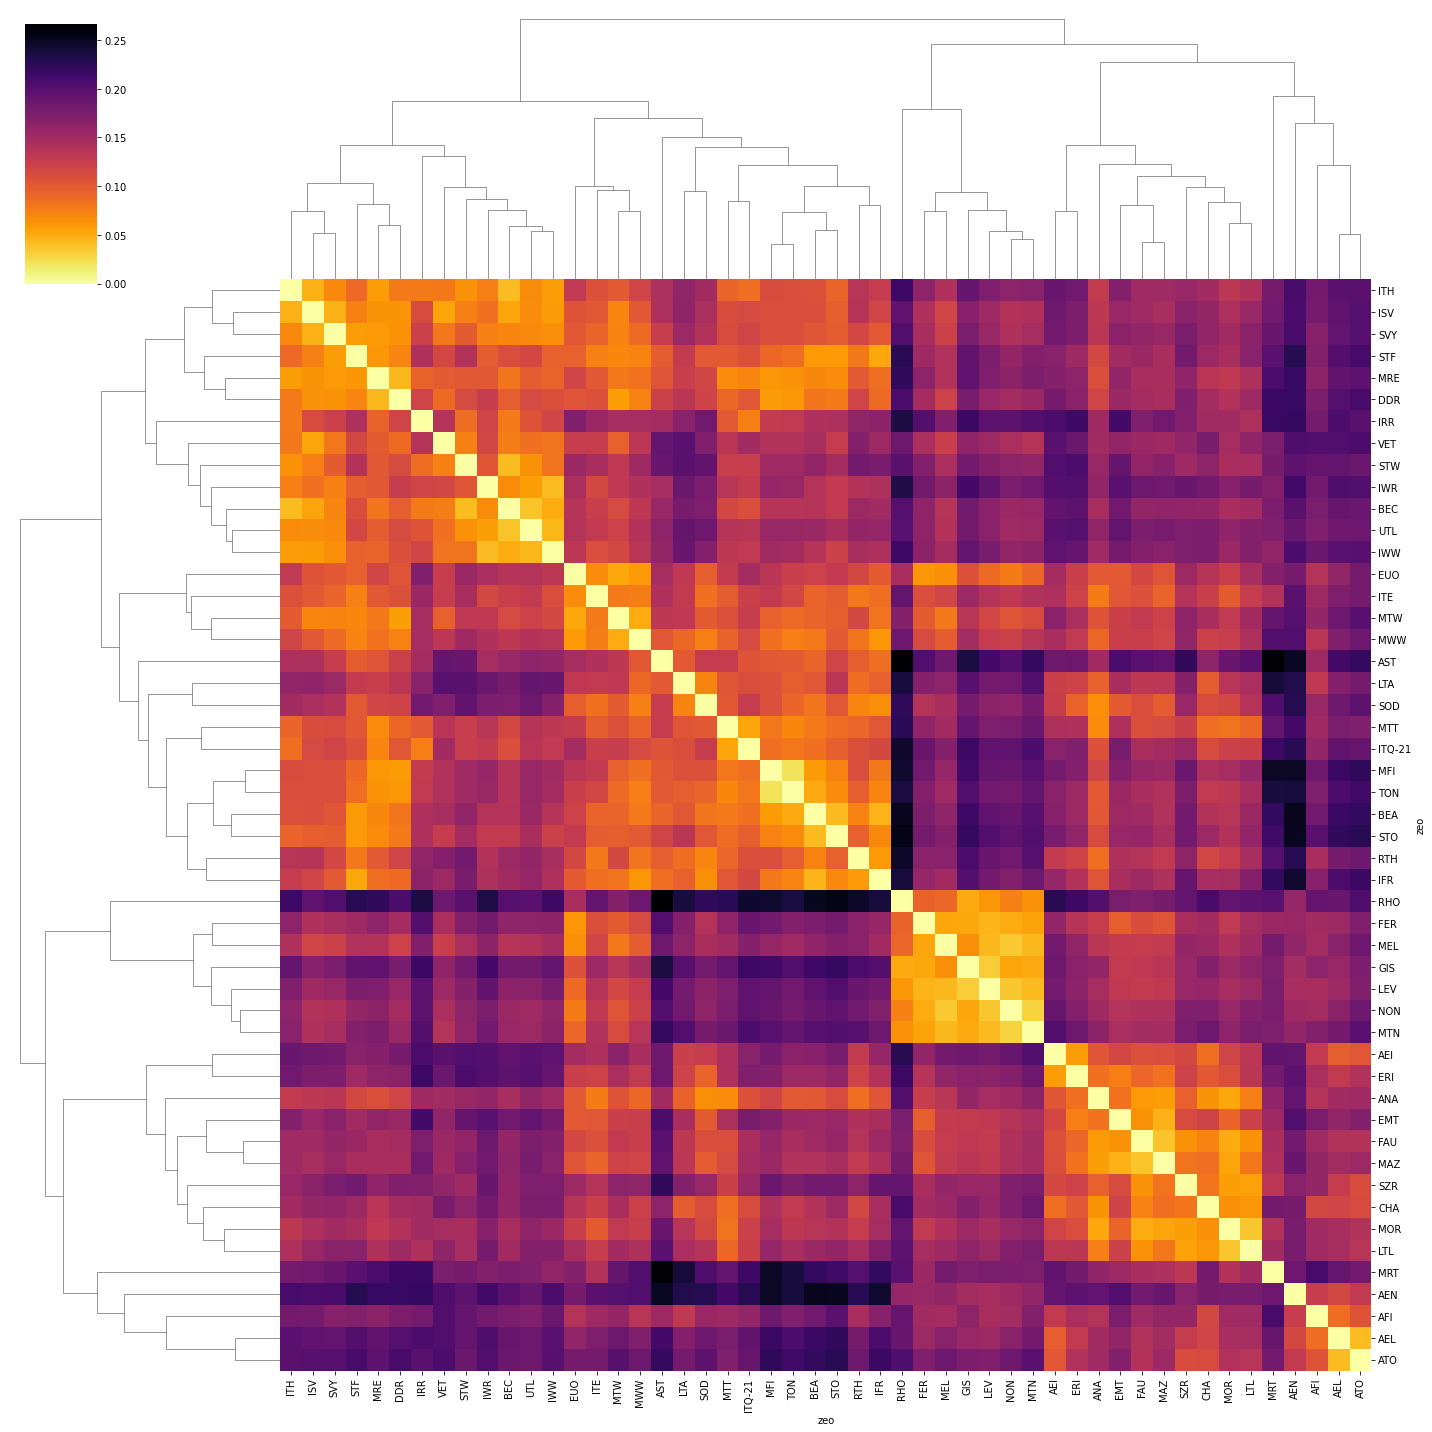

In [10]:
sns.clustermap(zeo_rmsd, cmap = "inferno_r", figsize=(20, 20))

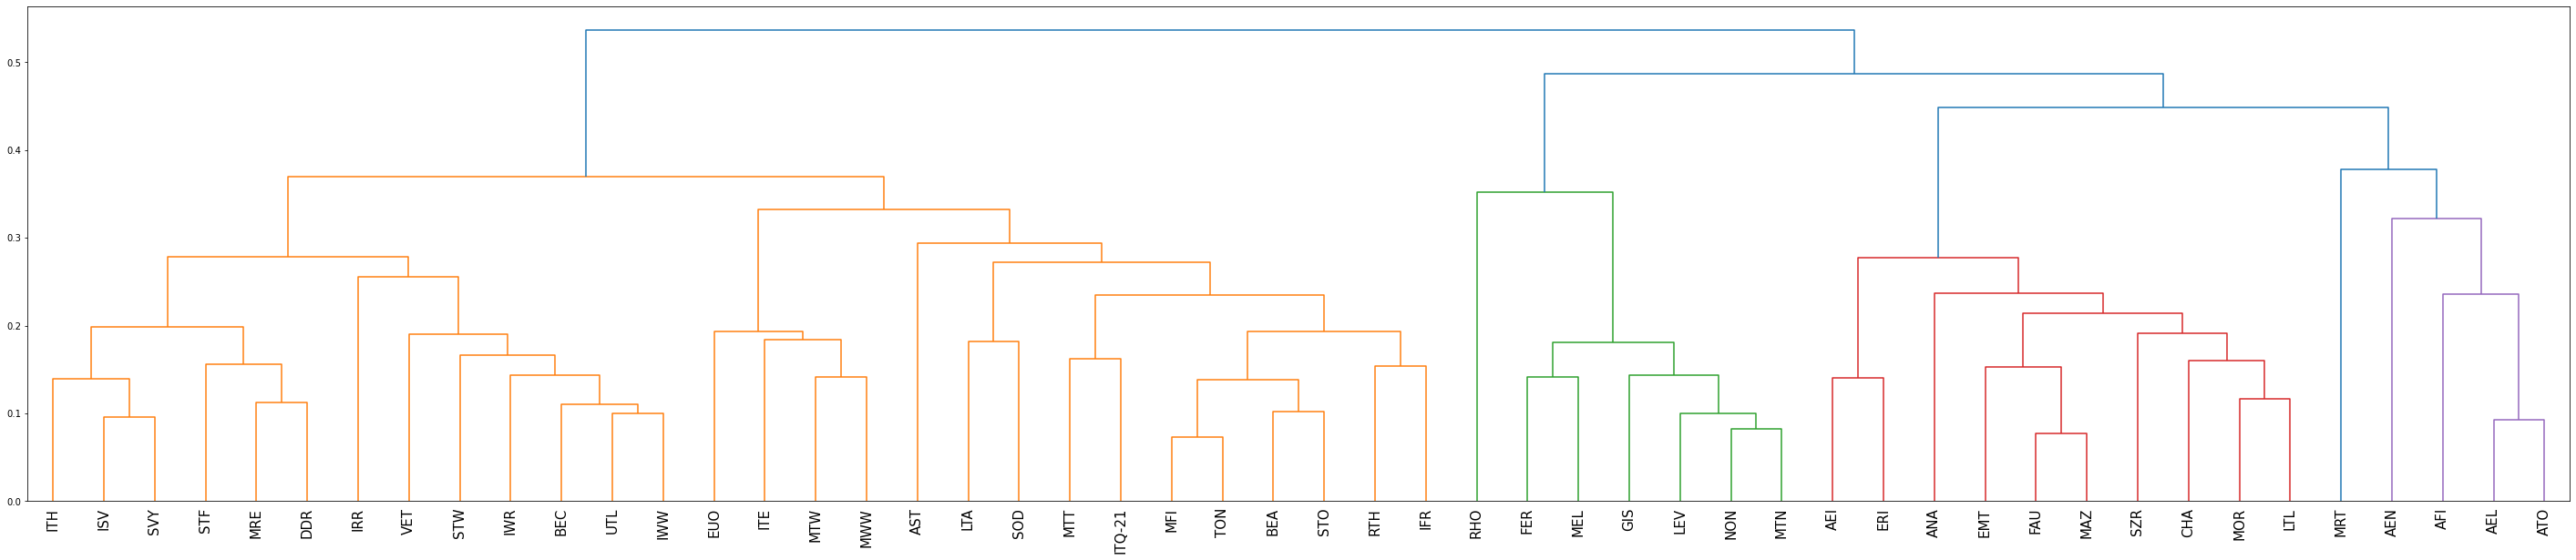

In [11]:
row_linkage = hierarchy.linkage(
    distance.pdist(zeo_rmsd.to_numpy()), method='average')

fig = plt.figure(figsize=(50, 10))
ax = fig.add_subplot(1, 1, 1)

dendro = hierarchy.dendrogram(row_linkage, labels = zeo_rmsd.columns.tolist(), ax = ax)
ax.tick_params(axis='x', which='major', labelsize=15)

plt.show()

In [14]:
def plot_dendrogram(icoord,dcoord,figsize, osda_labels = [], polar=False):
    if polar:
        radius = 20 # radius of circle
        dcoord = -dcoord*radius
#         dcoord = -np.log(dcoord+1)*radius
        gap = 0.1
        imax = icoord.max()
        imin = icoord.min()
        icoord = ((icoord - imin)/(imax - imin)*(1-gap) + gap/2)*2*np.pi
        
    with plt.style.context("seaborn-white"):
        fig = plt.figure(figsize=figsize, dpi=500)
        ax = fig.add_subplot(111, polar=polar)
        
        for xs, ys in zip(icoord, dcoord):
            start, end = xs[0], xs[2]
            
            # Default colors
            color = 'black'
            linewidth = 3
            
#             # Grp A
#             if (start > 0) and (end < 1.2) and (ys[1] > -12):
#                 color     = 'tab:red'
#                 linewidth = 7
                
#             # Grp B
#             if (start > 1.2) and (end < 2.4) and (ys[1] > -12):
#                 color     = 'tab:green'
#                 linewidth = 7
                
#             # Grp C
#             if (start > 2.4) and (end < 3.0) and (ys[1] > -12):
#                 color     = 'tab:blue'
#                 linewidth = 7
            
#             # Grp D
#             if (start > 3.0) and (end < 4.8) and (ys[1] > -12):
#                 color     = 'tab:purple'
#                 linewidth = 7
            
#             # Grp E
#             if (start > 4.8) and (end < 6.0) and (ys[1] > -12):
#                 color     = 'tab:orange'
#                 linewidth = 7
            
            if polar:
                xs = smoothsegment(xs)
                ys = smoothsegment(ys)
                
            
            ax.plot(xs,ys, color=color, 
                        linewidth=linewidth
                       )
        if polar:
            ax.spines['polar'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
#             ax.set_rlabel_position(0)
            Nxticks = len(osda_labels)
            xticks = np.linspace(gap/2, 1-gap/2, Nxticks)
            ax.set_xticks(xticks*np.pi*2)

            ax.set_xticklabels(osda_labels)
            ax.xaxis.grid(False)
            
            
            labels = []
            mol_vols = [] # molecule vol
            mol_asphs = [] # molecule asphericity
            num_zeos = [] # OSDA specificity
            pore_sizes = []
            ring_sizes = []
            angles = []
            for label, angle in zip(ax.get_xticklabels(), xticks*np.pi*2):
                
                x,y = angle, 0
                lab = ax.text(x,y, label.get_text(), 
                              transform=label.get_transform(),
                              ha=label.get_ha(), va=label.get_va(),
                             fontsize = 20,
                             )
                degrees = np.degrees(angle)
                if degrees > 90 and degrees < 270:
                    degrees = degrees + 180
                lab.set_rotation(degrees)
                labels.append(lab)
                
                
# #                 Draw molecule
#                 smiles = label.get_text()
#                 mol = Chem.MolFromSmiles(smiles)
#                 o = Draw.MolDrawOptions()
#                 o.bondLineWidth = 5
#                 mol_img = Draw.MolToImage(mol, options=o, size=(300, 300))
#                 r = 0.41 # radius of molecule images in fractional
#                 x_cor, y_cor = -0.01, -0.02 # correction in x y fractions
#                 img_ax = fig.add_axes([0.5+r*np.cos(angle)+x_cor,0.5+r*np.sin(angle)+y_cor,0.045,0.045], anchor='C', zorder=1)
#                 img_ax.imshow(mol_img)
#                 img_ax.axis('off')
    
#                 # Get properties
#                 mol_vol = df_osda_all_feats[df_osda_all_feats['osda smiles'] == smiles]['osda_volume_mean_0'].item()
#                 mol_asph = df_osda_all_feats[df_osda_all_feats['osda smiles'] == smiles]['osda_asphericity_mean_0'].item()
            
#                 num_zeo = 1/len(df[(df['osda1 smiles'] == smiles) 
# #                                  & (df.index.isin(SiAl.index))
#                                 ]['Code1'].value_counts())
                
#                 ring_size = df_zeos[df_zeos['Code'].isin(df[(df['osda1 smiles'] == smiles) 
# #                                  & (df.index.isin(SiAl.index))
#                                 ]['Code1'].value_counts().index)]['ring_size_0'].mean()
                
#                 pore_rads = df_zeos[df_zeos['Code'].isin(df[(df['osda1 smiles'] == smiles) 
# #                                  & (df.index.isin(SiAl.index))
#                                 ]['Code1'].value_counts().index)]['largest_included_sphere']/2. # pore radiuses of all zeolites formed by this OSDA
#                 pore_size = (4/3*np.pi*(pore_rads**3)).median() # mean of pore volume of all zeolites formed by this OSDA
                
                
                
#                 # annotate with property - OSDA asphericity
#                 x,y = angle, -0.20
#                 lab = ax.text(x,y, round(mol_asph, 3), 
#                               transform=label.get_transform(),
#                               ha=label.get_ha(), va=label.get_va(),
#                              fontsize = 30,
#                              )
#                 degrees = np.degrees(angle)
#                 if degrees > 90 and degrees < 270:
#                     degrees = degrees + 180
#                 lab.set_rotation(degrees)
#                 labels.append(lab)
                
               
                # angles.append(angle)
                # mol_vols.append(mol_vol)
                # mol_asphs.append(mol_asph)
                # num_zeos.append(num_zeo)
                # pore_sizes.append(pore_size)
                # ring_sizes.append(ring_size)
            
            ax.set_xticklabels([])
            ax.set_ylim(top = 2)
            
            
            # Define angles
            n = len(unique_zeos)
            step_size = (angles[-1] - angles[0])/(n-1) # step size in radians
            start = angles[0] - step_size/2 # start angle in radians
            end   = angles[-1] + step_size/2# end angle in radians
            a = np.linspace(start, end, n+1) # angles
            
            # Plot property colors - OSDA mol vol
            rad = np.linspace(0, 0.8, n) # radius of coloring, 1st and 2nd correspond to start and end of radius. 0 correspond to outmost radius
            r, th = np.meshgrid(rad, a)
            z = np.array(mol_vols)
            z = np.vstack(n*[z]).T
            print(th.shape, r.shape, z.shape)
            mesh = ax.pcolormesh(th, r, z, cmap ='Oranges')
            ax.plot(a, r, ls='none') 
            cbar_pos = fig.add_axes([0.78,0.43,0.01,0.15])
            cbar = fig.colorbar(mappable = mesh, cax=cbar_pos, ticks=np.arange(0, 500, 100))
            cbar.ax.set_yticklabels(np.arange(0, 500, 100))
            cbar.set_label(label = 'OSDA molecular \n volume ($\AA^3$)', size=30, rotation=270, labelpad=70)
            cbar.ax.tick_params(labelsize=20) 
            
        #     # Plot property colors - zeolite pore volume
        #     rad = np.linspace(1.0, 1.8, n) # radius of coloring, 1st and 2nd correspond to start and end of radius. 0 correspond to outmost radius
        #     r, th = np.meshgrid(rad, a)
        #     z = np.array(pore_sizes)
        #     z = np.vstack(n*[z]).T
        #     mesh = ax.pcolormesh(th, r, z, cmap ='Purples', 
        #                          vmin=100, vmax= 200,
        #                          norm = LogNorm()
        #                         )
        #     ax.plot(a, r, ls='none')
        #     cbar_pos = fig.add_axes([0.87,0.43,0.01,0.15])
        #     cbar = fig.colorbar(mappable = mesh, cax=cbar_pos
        #                         , ticks=[100, 200],
        #                        )
        #     cbar.ax.set_yticklabels(['100', '$\geq$200'])
        #     cbar.ax.minorticks_off()
        #     cbar.set_label(label = 'Zeolite largest included \n sphere volume ($\AA^3$)', size=30, rotation=270, labelpad=40)
        #     cbar.ax.tick_params(labelsize=20) 
        
        # fig.savefig('figures/osda_dendrogram.jpg', bbox_inches='tight', transparent=True, dpi = 500)

        # print(scipy.stats.pearsonr(mol_vols, pore_sizes))
        # print(scipy.stats.spearmanr(mol_vols, pore_sizes))
        
        
                
    return fig, ax

labels = zeo_feats_T_scaled.columns.tolist()
cols = [labels[i] for i in dendro['leaves']]

fig, ax = plot_dendrogram(np.array(dendro['icoord']), np.array(dendro['dcoord']), (30,30), 
                osda_labels = cols, polar = True)
fig.show()

IndexError: list index out of range